In [1]:
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import os
import sys
import glob
import argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

%pylab inline

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/lyz/.local/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.11) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [35]:
train_df = pd.read_csv('./input/人员聚集识别挑战赛数据集/train_label.csv')
train_df['path'] = './input/人员聚集识别挑战赛数据集/train/' + train_df['name']
# np.random.shuffle(train_path)

In [36]:
train_df.head()

,name,count,path
0,mhTTqKoHOb.jpg,90,./input/人员聚集识别挑战赛数据集/train/mhTTqKoHOb.jpg
1,uEEMGtcAsu.jpg,14,./input/人员聚集识别挑战赛数据集/train/uEEMGtcAsu.jpg
2,rbLlYPkBAJ.jpg,74,./input/人员聚集识别挑战赛数据集/train/rbLlYPkBAJ.jpg
3,FzosxVdhns.jpg,208,./input/人员聚集识别挑战赛数据集/train/FzosxVdhns.jpg
4,xdCWXNwkOl.jpg,300,./input/人员聚集识别挑战赛数据集/train/xdCWXNwkOl.jpg


In [37]:
train_df['count'] /= 100

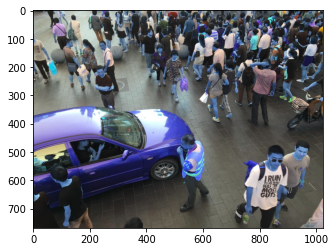

In [38]:
plt.imshow(cv2.imread(train_df['path'].iloc[0]))

In [39]:
test_df = pd.read_csv('./input/人员聚集识别挑战赛数据集/sample_submit.csv')
test_df['path'] = './input/人员聚集识别挑战赛数据集/test/' + test_df['name']

In [40]:
class XunFeiDataset(Dataset):
    def __init__(self, img_path, label, transform=None):
        self.img_path = img_path
        self.label = label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = cv2.imread(self.img_path[index])
        img = img.astype(np.float32)

        img /= 255.0
        img -= 0.5

        if self.transform is not None:
            img = self.transform(image=img)['image']
        img = img.transpose([2, 0, 1])

        return img, torch.from_numpy(np.array(self.label[index]))

    def __len__(self):
        return len(self.img_path)

In [41]:
class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()

        model = models.resnet18(True)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Linear(512, 1)
        self.resnet = model

    def forward(self, img):
        out = self.resnet(img)
        return out

In [66]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output[:, 0], target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 40 == 0:
            print(loss.item())

        train_loss += loss.item()

    return train_loss/len(train_loader)


def validate(val_loader, model, criterion):
    model.eval()

    val_acc = 0.0

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)
            val_acc += (output[:, 0] - target).abs().sum().item()

    return (val_acc / len(val_loader.dataset)) * 100


def predict(test_loader, model, criterion):
    model.eval()

    test_pred = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            test_pred.append(output.data.cpu().numpy())

    return np.vstack(test_pred)

In [67]:
import albumentations as A

train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_df['path'].values[:-200], train_df['count'].values[:-200],
                  A.Compose([
                      A.Resize(300, 300),
                      # A.RandomCrop(300, 750),
                      A.HorizontalFlip(p=0.5),
                      A.RandomContrast(p=0.5),
                      A.RandomBrightnessContrast(p=0.5),
                      ])
                  ), batch_size=5, shuffle=True, num_workers=1, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_df['path'].values[-200:], train_df['count'].values[-200:],
                  A.Compose([
                      A.Resize(300, 300),
                      # A.RandomCrop(450, 750),
                      # A.HorizontalFlip(p=0.5),
                      # A.RandomContrast(p=0.5),
                      ])
                  ), batch_size=2, shuffle=False, num_workers=1, pin_memory=False
)

# test_loader = torch.utils.data.DataLoader(
#     XunFeiDataset(test_df['path'].values,
#             A.Compose([
#             # A.Resize(300, 300),
#             A.RandomCrop(130, 450),
#             # A.HorizontalFlip(p=0.5),
#             # A.RandomContrast(p=0.5),
#         ])
#     ), batch_size=10, shuffle=False, num_workers=1, pin_memory=False
# )

In [74]:
model = XunFeiNet()
model = model.to('cuda')
criterion = nn.L1Loss().cuda()
optimizer = torch.optim.SGD(model.parameters(), 0.001)

In [75]:
for _ in range(20):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_loss = validate(val_loader, model, criterion)
    print(train_loss, val_loss)

1.1318563222885132
1.287915825843811
0.6995322704315186
4.329068660736084
1.7710228131285735 132.7943056595395
2.540966510772705
0.3791281580924988
1.2864559888839722
1.1219886541366577
1.520945778489113 130.96473682992163
2.3079731464385986
0.747489333152771
1.5027660131454468
1.5850056409835815
1.4285729101725988 108.78714452125135
0.9213108420372009
0.3693559765815735
1.2964609861373901
0.7108353972434998
1.4429967337421008 91.49353580836207
3.4813218116760254
0.8464269042015076
0.6350147128105164
1.2586427927017212
1.391497658405985 85.06338704764842
1.6642646789550781
0.5779550075531006
2.857391119003296
1.1143652200698853
1.38800864645413 79.47543719001114
1.5855133533477783
0.9672512412071228
1.4637213945388794
0.4117327332496643
1.487684637095247 96.81877694096418
1.1637529134750366
1.6942026615142822
6.025054454803467
2.812028169631958
1.3853566883930137 94.79734087705614
0.5405675768852234
0.5493687987327576
4.461000919342041
1.1021788120269775
1.3317049948232516 79.651076408

In [76]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_df['path'].values, [0] * test_df.shape[0],
                  A.Compose([
                      A.Resize(300, 300),
                      # A.RandomCrop(450, 750),
                      A.HorizontalFlip(p=0.5),
                      A.RandomContrast(p=0.5),
                      ])
                  ), batch_size=10, shuffle=False, num_workers=1, pin_memory=False
)

pred = None

for _ in range(5):
    if pred is None:
        pred = predict(test_loader, model, criterion)
    else:
        pred += predict(test_loader, model, criterion)
        
pred /=5
pred *= 100

/home/lyz/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


# Test

In [80]:
submit = pd.DataFrame(
    {
        'name': [x.split('/')[-1] for x in test_df['path'].values],
        'count': pred.reshape(-1).astype(int)
        })

In [81]:
# test_df = pd.read_csv('提交示例.csv')
# test_df['label'] = pred.argmax(1)

# submit = submit.sort_values(by='id')
# test_df.to_csv('submit2.csv', index=None)

In [82]:
submit.to_csv('sub.csv', index=None)